In [6]:
import socnavgym
import gymnasium as gym
from socnavgym.wrappers import DiscreteActions
from socnavgym.wrappers import CardinalActions
from rl.QLearning import *
from rl.MSR import *
from rl.SR import *
from rl.SF import *
from rl.DQN import *
from rl.DSR import *
from rl.SRQ import *
from tqdm.auto import trange
import imageio
from utils.StateDiscretizer import *
from utils.TileCoder import *

In [7]:
env = gym.make("SocNavGym-v1", config="./configs/no_humans.yaml") 
env = DiscreteActions(env)

SEED = 5
EPISODES = 50

discretizer = StateDiscretizer(xy_bins=30, env=env)

In [8]:
agent = SR(
            action_size=7,
            learning_rate=0.2,
            r_learning_rate=0.4,
            gamma=0.99, epsilon=0.05, discretizer=discretizer
        )

rewards_sr = []
length_sr = []

for episode in trange(EPISODES):
    obs = env.reset(seed=SEED)
    episodes_length, episodes_rewards = agent.act(env, obs)
    length_sr.append(episodes_length)
    rewards_sr.append(episodes_rewards)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
obs, _ = env.reset(seed=SEED)
frames = []
for i in range(600):
    obs, reward, terminated, truncated, info = env.step(agent.sample_action(agent.get_state_key(obs)))
    frame = env.render()
    frames.append(frame)
    if terminated or truncated:
        break

env.close()
imageio.mimsave("videos/sr.gif", frames, fps=20)

Non-grid state keys (ignored in grid plots):
   (10, 27, 4)
   (1, 17, 2)
   (2, 17, 2)
   (5, 5, 14)
   (17, 2, 12)
   (27, 10, 10)
   (25, 22, 7)
   (14, 27, 5)
   (26, 10, 10)
   (16, 2, 12)
   (5, 6, 14)
   (3, 18, 2)
   (11, 26, 4)
   (22, 24, 7)
   (26, 13, 9)
   (20, 4, 11)
   (8, 4, 13)
   (3, 14, 2)
   (8, 24, 4)
   (19, 26, 6)
   (26, 17, 8)
   (23, 6, 10)
   (12, 3, 13)
   (3, 10, 1)
   (13, 3, 13)
   (23, 7, 10)
   (4, 10, 1)
   (5, 10, 1)
   (5, 21, 3)
   (15, 26, 5)
   (24, 20, 8)
   (24, 10, 10)
   (23, 20, 8)
   (15, 25, 5)
   (6, 20, 3)
   (7, 20, 3)
   (5, 11, 1)
   (12, 5, 13)
   (21, 7, 10)
   (13, 5, 13)
   (14, 5, 13)
   (6, 10, 1)
   (6, 19, 3)
   (14, 24, 5)
   (22, 20, 8)
   (7, 19, 3)
   (23, 11, 10)
   (16, 6, 12)
   (8, 8, 14)
   (6, 16, 3)
   (11, 23, 5)
   (5, 16, 3)
   (16, 5, 12)
   (5, 17, 3)
   (7, 8, 14)
   (9, 8, 14)
   (17, 6, 12)
   (20, 22, 7)
   (19, 22, 7)
   (10, 23, 5)
   (5, 15, 3)
   (9, 7, 14)
   (18, 6, 12)
   (8, 7, 14)
   (17, 5, 12)
   

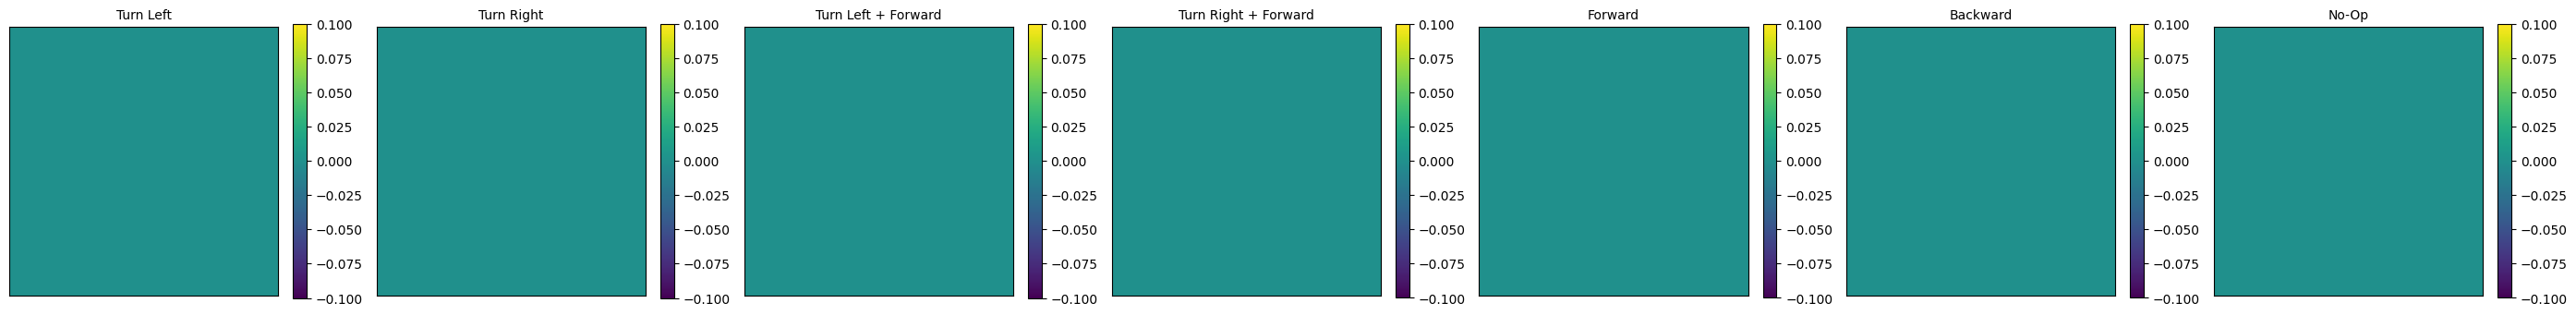

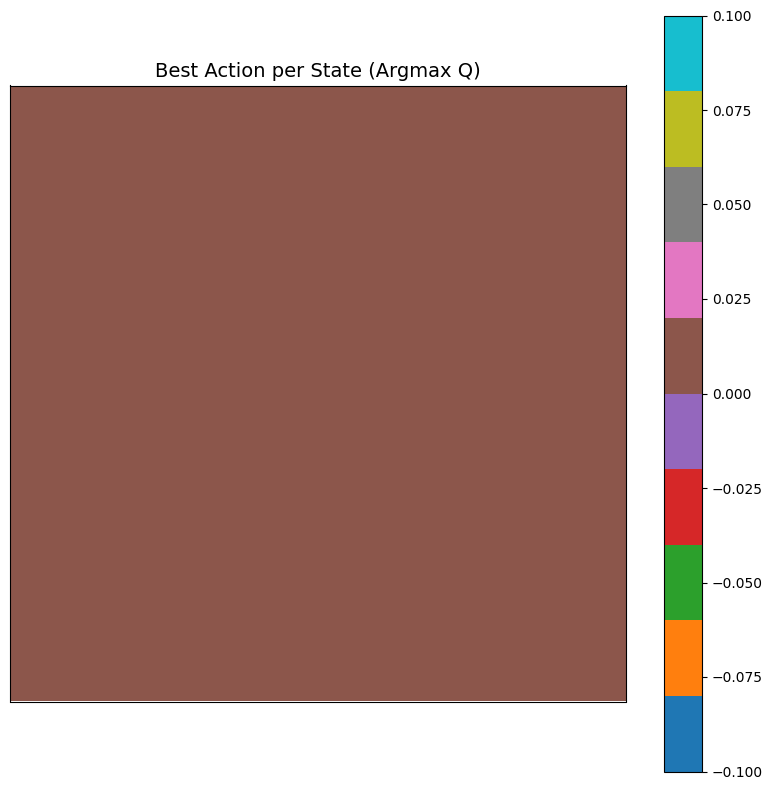

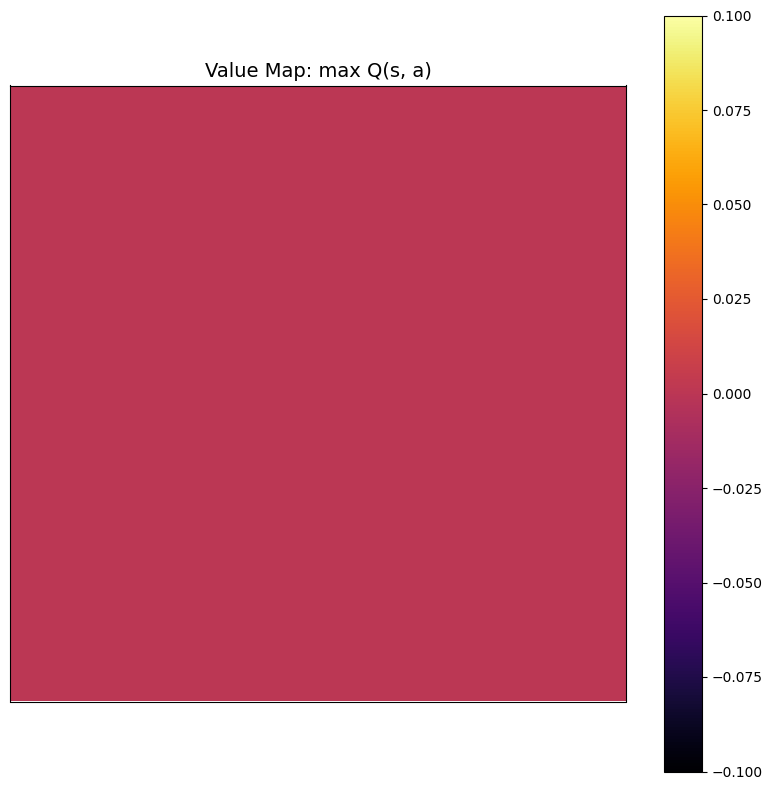

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# Assumptions:
# - agent is an instance of SR
# - Grid is 30 x 30
# - agent.action_size == 7
# - State keys for normal states are (row, col) with 0 <= row,col < 30
# - There is a special terminal key "0" (or other non-tuple keys) in agent.SR
#   that we must ignore for grid plotting.
# ----------------------------------------------------------------------

H = W = 30
A = agent.action_size  # should be 7

# ----------------------------------------------------------------------
# Optional: show which non-grid keys exist (e.g., the special 0 key)
# ----------------------------------------------------------------------
print("Non-grid state keys (ignored in grid plots):")
for k in agent.SR.keys():
    if not (isinstance(k, tuple) and len(k) == 2):
        print("  ", k)

# ----------------------------------------------------------------------
# Build a full Q-table over the 30x30 grid.
# For any state (i, j) that was never visited, _q_values will still work:
# SR[state][a] will be empty -> Q is all zeros.
# This way we don't need to iterate agent.SR.keys and we automatically
# avoid the special key 0 (or any other non-tuple keys).
# ----------------------------------------------------------------------
Q_table = np.zeros((H, W, A), dtype=np.float32)

for i in range(H):
    for j in range(W):
        state_key = (i, j)
        Q_table[i, j, :] = agent._q_values(state_key)

# ----------------------------------------------------------------------
# 1) Per-action Q-value heatmaps
# ----------------------------------------------------------------------
action_names = [
    "Turn Left",             # 0
    "Turn Right",            # 1
    "Turn Left + Forward",   # 2
    "Turn Right + Forward",  # 3
    "Forward",               # 4
    "Backward",              # 5
    "No-Op",                 # 6
]

fig, axes = plt.subplots(1, A, figsize=(4 * A, 4))

for a in range(A):
    ax = axes[a]
    img = ax.imshow(Q_table[:, :, a], cmap="viridis")
    ax.set_title(action_names[a], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(img, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 2) Best action per state (policy map)
# ----------------------------------------------------------------------
# Flatten last axis to compute argmax over actions
best_action = np.argmax(Q_table, axis=2)  # shape (30, 30)

plt.figure(figsize=(8, 8))
plt.imshow(best_action, cmap="tab10")
plt.title("Best Action per State (Argmax Q)", fontsize=14)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 3) Value map: max_a Q(s, a)
# ----------------------------------------------------------------------
V = np.max(Q_table, axis=2)  # shape (30, 30)

plt.figure(figsize=(8, 8))
plt.imshow(V, cmap="inferno")
plt.title("Value Map: max Q(s, a)", fontsize=14)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()
